## 視覺化

### 先照之前的，讀取資料

In [1]:
import tqdm
import tarfile
import pandas
import matplotlib.pyplot as plt
import numpy as np
import PIL
import gzip
from urllib.request import urlopen
%matplotlib inline
# progress bar
tqdm.tqdm.pandas()

# 檔案名稱格式
filename_format="M06A_{year:04d}{month:02d}{day:02d}.tar.gz".format
xz_filename_format="xz/M06A_{year:04d}{month:02d}{day:02d}.tar.xz".format
csv_format = "M06A/{year:04d}{month:02d}{day:02d}/{hour:02d}/TDCS_M06A_{year:04d}{month:02d}{day:02d}_{hour:02d}0000.csv".format

# 設定欄位名稱
M06A_fields = ['VehicleType',
               'DetectionTime_O','GantryID_O',
               'DetectionTime_D','GantryID_D ',
               'TripLength', 'TripEnd', 'TripInformation']
import datetime
# 用來解析時間格式
def strptime(x):
    return datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

def parse_tripinfo(tripinfo):
    split1 = tripinfo.split("; ")
    split2 = (x.split('+') for x in split1)
    return [(strptime(t), node) for t,node in split2]

In [2]:
## 讀取檔案
node_data=pandas.read_json('node_data.json')
speedlimit = pandas.read_json('speedlimit.json')

## 依照速限來找更多的超速

In [3]:
# 這個改了一點， SpeedInfo 這個 named tuple 同時紀錄了區段的起始時間和兩端點
from collections import namedtuple
SpeedInfo = namedtuple("SpeedInfo", ["speed", "time","loc1", "loc2"])

def compute_speed(trip):
    rtn = []
    for (t1,n1), (t2,n2) in zip(trip[:-1], trip[1:]):
        if n1[:3] != n2[:3] or n1[-1]!=n2[-1]:
            continue
        if n1[3]=='R' or n2[3]=='R': 
            continue
        km1 = int(n1[3:-1])/10
        km2 = int(n2[3:-1])/10
        hr_delta = time_delta.total_seconds()/60/60
        speed = abs(km2-km1)/hr_delta
        rtn.append(SpeedInfo(speed, t1, n1, n2))
    return rtn 

In [4]:
# 打開剛才下載的檔案試試
data_config ={"year":2016, "month":12, "day":18}
tar = tarfile.open(filename_format(**data_config), 'r')

# 如果沒有下載，可以試試看 xz 檔案
#data_dconfig ={"year":2016, "month":11, "day":18}
#tar = tarfile.open(xz_filename_format(**data_config), 'r')

In [5]:
csvs = (tar.extractfile(csv_format(hour=hr, **data_config)) for hr in tqdm.trange(24))
data = pandas.concat([pandas.read_csv(csv, names=M06A_fields) for csv in csvs])
print("資料大小", data.shape)
# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])
# 去除異常資料
data = data[data.TripEnd == 'Y']
# 只保留 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]

data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)
data['Speed'] = data.Trip.progress_apply(compute_speed)

100%|██████████| 24/24 [00:39<00:00,  1.55s/it]


資料大小 (3350606, 8)
異常資料數: 0


100%|██████████| 3350606/3350606 [00:52<00:00, 64236.17it/s] 


In [6]:
speedlimit_lookup = node_data.速限.to_dict()

def is_speeding(info):
    speedlimit = max(speedlimit_lookup[info.loc1], speedlimit_lookup[info.loc2])
    return info.speed > speedlimit + 10

# 存下所有超速的判斷
data['超速紀錄'] = data.Speed.progress_apply(lambda l:[is_speeding(x) for x in l])


100%|██████████| 3350606/3350606 [00:38<00:00, 87844.77it/s] 


In [7]:
data.head(10)

,VehicleType,TripInformation,Trip,Speed,超速紀錄
0,31,2016-12-18 00:31:53+03F2079S; 2016-12-18 00:32...,"[(2016-12-18 00:31:53, 03F2079S), (2016-12-18 ...","[(123.93442622950788, 2016-12-18 00:31:53, 03F...",[True]
1,31,2016-12-18 00:37:31+03F2194S; 2016-12-18 00:40...,"[(2016-12-18 00:37:31, 03F2194S), (2016-12-18 ...","[(117.65853658536565, 2016-12-18 00:37:31, 03F...",[False]
2,31,2016-12-18 00:47:56+03F2415S,"[(2016-12-18 00:47:56, 03F2415S)]",[],[]
3,31,2016-12-18 00:22:29+01H0447N; 2016-12-18 00:29...,"[(2016-12-18 00:22:29, 01H0447N), (2016-12-18 ...","[(99.75903614457827, 2016-12-18 00:29:45, 01F0...","[False, False, False]"
4,31,2016-12-18 00:35:55+01F0633S; 2016-12-18 00:37...,"[(2016-12-18 00:35:55, 01F0633S), (2016-12-18 ...","[(106.28571428571458, 2016-12-18 00:35:55, 01F...","[False, True, False, False, False, False, Fals..."
5,32,2016-12-18 00:21:00+05F0438N; 2016-12-18 00:22...,"[(2016-12-18 00:21:00, 05F0438N), (2016-12-18 ...",[],[]
6,32,2016-12-18 00:10:59+01F0005S; 2016-12-18 00:11...,"[(2016-12-18 00:10:59, 01F0005S), (2016-12-18 ...","[(86.39999999999999, 2016-12-18 00:10:59, 01F0...","[False, False, False, False, False, False, Fal..."
7,31,2016-12-18 00:35:09+01F0017N,"[(2016-12-18 00:35:09, 01F0017N)]",[],[]
8,31,2016-12-18 00:26:36+01F1621S; 2016-12-18 00:28...,"[(2016-12-18 00:26:36, 01F1621S), (2016-12-18 ...","[(115.52238805970178, 2016-12-18 00:26:36, 01F...","[True, True]"
9,31,2016-12-18 00:18:25+01F3525S; 2016-12-18 00:20...,"[(2016-12-18 00:18:25, 01F3525S), (2016-12-18 ...","[(99.69230769230833, 2016-12-18 00:18:25, 01F3...","[False, True, False]"


In [26]:
num_total = data.shape[0]
num_valid = data.Speed.astype(bool).sum()
num_overspeed = speeding_idx.sum()
num_total, num_valid, num_overspeed, num_overspeed/num_total, num_overspeed/num_valid

(3350606, 2347875, 350227, 0.10452646476488134, 0.14916765159985093)

In [15]:
S01F = list(sorted(x for x in node_data.編號 if x.startswith('01F') and x.endswith('S')))

In [17]:
S01F = {s:i for i,s in enumerate(S01F)}

In [18]:
len(S01F)

73

In [31]:
speedlimit_lookup = node_data.速限.to_dict()
start_time = datetime.datetime(data_config['year'],data_config['month'],data_config['day'])
end_time = datetime.datetime(data_config['year'],data_config['month'],data_config['day']+1)
total_statistics=np.zeros((24*4, len(S01F)), dtype=int)
speeding_statistics=np.zeros((24*4, len(S01F)), dtype=int)

def count_speeding(info):
    if not info.loc1.startswith('01F'):
        return
    if not info.loc1.endswith('S'):
        return
    if info.loc1 > info.loc2:
        return

    idx = int((info.time-start_time).seconds/(15*60))
    idx2 = S01F[info.loc1]
    total_statistics[idx][idx2] += 1
    speedlimit = max(speedlimit_lookup[info.loc1], speedlimit_lookup[info.loc2])
    if info.speed > speedlimit + 10:
        speeding_statistics[idx][idx2] += 1

# 存下所有超速的判斷
data.Speed.apply(lambda l:[count_speeding(x) for x in l]);



 43%|████▎     | 1448154/3350606 [00:13<00:13, 141579.92it/s]

2016-12-19 00:00:08 0
2016-12-19 00:01:19 0
2016-12-19 00:02:58 0
2016-12-19 00:06:10 0
2016-12-19 00:08:38 0
2016-12-19 00:10:57 0
2016-12-19 00:14:24 0
2016-12-19 00:17:19 1
2016-12-19 00:21:29 1
2016-12-19 00:24:47 1
2016-12-19 00:28:03 1
2016-12-19 00:34:49 2
2016-12-19 00:37:31 2
2016-12-19 00:38:54 2
2016-12-19 00:43:10 2
2016-12-19 00:46:25 3
2016-12-19 00:48:16 3
2016-12-19 00:53:25 3
2016-12-19 00:55:30 3
2016-12-19 00:58:38 3



 58%|█████▊    | 1934915/3350606 [00:17<00:11, 124291.69it/s]

2016-12-19 00:03:16 0
2016-12-19 00:08:17 0



 62%|██████▏   | 2072204/3350606 [00:18<00:10, 121777.20it/s]

2016-12-19 01:08:19 4
2016-12-19 01:09:54 4
2016-12-19 01:10:47 4
2016-12-19 01:14:33 4
2016-12-19 01:21:10 5
2016-12-19 01:23:44 5
2016-12-19 01:24:57 5
2016-12-19 01:26:26 5
2016-12-19 01:30:02 6
2016-12-19 01:34:21 6
2016-12-19 01:43:04 6
2016-12-19 01:48:40 7
2016-12-19 01:53:06 7
2016-12-19 01:59:12 7
2016-12-19 02:06:40 8
2016-12-19 02:09:08 8
2016-12-19 02:12:35 8
2016-12-19 00:07:47 0
2016-12-19 00:13:41


 63%|██████▎   | 2111297/3350606 [00:19<00:09, 126685.55it/s]

 0
2016-12-19 00:18:18 1
2016-12-19 00:24:37 1
2016-12-19 00:27:17 1
2016-12-19 00:29:35 1
2016-12-19 00:32:59 2
2016-12-19 00:35:53 2
2016-12-19 00:12:55 0
2016-12-19 00:21:30 1
2016-12-19 00:24:32 1
2016-12-19 00:25:58 1
2016-12-19 00:09:11 0
2016-12-19 00:12:01 0
2016-12-19 00:16:20 1
2016-12-19 00:20:05 1
2016-12-19 00:25:21 1
2016-12-19 00:45:07 3
2016-12-19 00:49:28 3
2016-12-19 00:51:21 3
2016-12-19 00:54:48 3
2016-12-19 00:56:36 3
2016-12-19 01:02:01 4
2016-12-19 01:06:16 4
2016-12-19 01:08:31 4
2016-12-19 01:14:57 4
2016-12-19 01:17:04 5
2016-12-19 01:20:33 5
2016-12-19 01:25:25 5
2016-12-19 01:28:54 5



 67%|██████▋   | 2245395/3350606 [00:20<00:08, 129735.25it/s]

2016-12-19 00:01:59 0
2016-12-19 00:05:06 0
2016-12-19 00:08:18 0
2016-12-19 00:12:09 0
2016-12-19 00:15:23 1



 69%|██████▉   | 2313398/3350606 [00:20<00:07, 134310.84it/s]

2016-12-19 00:01:09 0
2016-12-19 00:00:14 0
2016-12-19 00:05:33 0
2016-12-19 00:09:14 0
2016-12-19 00:11:36 0
2016-12-19 00:15:14 1
2016-12-19 00:17:47 1
2016-12-19 00:19:12 1
2016-12-19 00:21:09 1
2016-12-19 00:25:43 1
2016-12-19 00:27:29 1
2016-12-19 00:35:04 2
2016-12-19 00:38:57 2
2016-12-19 00:41:22 2
2016-12-19 00:43:04 2
2016-12-19 00:46:01 3
2016-12-19 00:48:04 3
2016-12-19 01:21:21 5



 70%|███████   | 2354479/3350606 [00:20<00:07, 136356.03it/s]

2016-12-19 01:07:01 4
2016-12-19 01:08:41 4
2016-12-19 01:13:08 4
2016-12-19 01:16:55 5
2016-12-19 00:03:45 0
2016-12-19 00:05:22 0
2016-12-19 00:17:15 1
2016-12-19 00:20:52 1
2016-12-19 00:25:56 1
2016-12-19 00:32:48 2
2016-12-19 00:37:43 2
2016-12-19 00:41:00 2
2016-12-19 00:45:30 3
2016-12-19 00:48:38 3
2016-12-19 00:50:27 3
2016-12-19 00:53:02 3
2016-12-19 00:59:09 3
2016-12-19 01:01:40 4
2016-12-19 01:06:38 4
2016-12-19 01:11:42 4
2016-12-19 01:14:31 4
2016-12-19 01:16:41 5
2016-12-19 01:20:18 5



 72%|███████▏  | 2396150/3350606 [00:21<00:06, 136852.57it/s]

2016-12-19 01:23:01 5
2016-12-19 00:14:45 0
2016-12-19 00:16:37 1
2016-12-19 00:26:55 1
2016-12-19 00:30:55 2
2016-12-19 00:33:07 2
2016-12-19 00:08:26 0
2016-12-19 00:11:56 0
2016-12-19 00:14:01 0
2016-12-19 00:15:34 1
2016-12-19 00:18:13 1
2016-12-19 00:20:03 1
2016-12-19 00:16:57 1
2016-12-19 00:19:11 1
2016-12-19 00:21:31 1
2016-12-19 00:24:39 1



 73%|███████▎  | 2437391/3350606 [00:21<00:06, 135773.53it/s]

2016-12-19 00:04:03 0
2016-12-19 00:06:31 0
2016-12-19 00:05:58 0
2016-12-19 00:11:44 0
2016-12-19 00:14:58 0
2016-12-19 00:17:24 1
2016-12-19 00:21:25 1
2016-12-19 00:24:35 1
2016-12-19 00:04:26 0
2016-12-19 00:08:18 0
2016-12-19 00:10:31 0
2016-12-19 00:16:30 1
2016-12-19 00:18:29 1
2016-12-19 00:21:51 1
2016-12-19 00:26:38 1
2016-12-19 00:29:57 1
2016-12-19 00:32:05 2
2016-12-19 00:35:14 2
2016-12-19 00:37:26 2
2016-12-19 00:38:40 2
2016-12-19 00:40:25 2
2016-12-19 00:44:42 2
2016-12-19 00:46:20 3
2016-12-19 00:49:56 3
2016-12-19 00:53:26 3
2016-12-19 00:55:31 3
2016-12-19 00:06:12 0
2016-12-19 00:09:50 0
2016-12-19 00:11:50 0
2016-12-19 00:13:22 0
2016-12-19 00:16:23 1
2016-12-19 00:18:30 1



 75%|███████▍  | 2506951/3350606 [00:22<00:06, 134743.24it/s]

2016-12-19 00:16:33 1
2016-12-19 00:20:48 1
2016-12-19 00:23:17 1
2016-12-19 00:25:10 1
2016-12-19 00:28:31 1
2016-12-19 00:30:57 2
2016-12-19 00:03:51 0
2016-12-19 00:10:36 0
2016-12-19 00:19:44 1
2016-12-19 00:22:31 1
2016-12-19 00:26:25 1
2016-12-19 00:29:33 1
2016-12-19 00:31:16 2
2016-12-19 00:33:29 2
2016-12-19 00:37:43 2
2016-12-19 00:41:25 2
2016-12-19 00:45:01 3
2016-12-19 00:51:06 3
2016-12-19 00:01:44 0
2016-12-19 00:09:27 0
2016-12-19 00:12:04 0
2016-12-19 00:16:25 1
2016-12-19 00:22:31 1
2016-12-19 00:26:51 1
2016-12-19 00:29:45 1
2016-12-19 00:33:48 2
2016-12-19 00:36:39 2
2016-12-19 00:38:20 2
2016-12-19 00:40:41 2
2016-12-19 00:46:10 3
2016-12-19 00:48:19 3
2016-12-19 00:52:47 3
2016-12-19 00:57:15 3
2016-12-19 00:59:50 3
2016-12-19 01:01:53 4
2016-12-19 01:05:24 4
2016-12-19 01:07:52 4



 76%|███████▌  | 2533866/3350606 [00:22<00:06, 133784.30it/s]

2016-12-19 02:15:32 9
2016-12-19 02:16:11 9
2016-12-19 02:18:32 9
2016-12-19 02:24:18 9
2016-12-19 02:25:40 9
2016-12-19 02:28:14 9
2016-12-19 02:32:17 10
2016-12-19 02:35:32 10
2016-12-19 02:38:51 10
2016-12-19 02:43:19 10
2016-12-19 02:46:52 11
2016-12-19 02:48:50 11
2016-12-19 02:50:55 11
2016-12-19 02:52:47 11
2016-12-19 02:57:37 11
2016-12-19 03:00:19 12
2016-12-19 02:02:56 8
2016-12-19 02:08:52 8
2016-12-19 01:01:59 4
2016-12-19 01:03:47 4
2016-12-19 01:04:43 4
2016-12-19 01:08:31 4
2016-12-19 01:15:48 5
2016-12-19 01:18:29 5
2016-12-19 01:19:45 5
2016-12-19 01:21:27 5
2016-12-19 01:25:04 5
2016-12-19 01:29:21 5
2016-12-19 01:38:51 6
2016-12-19 01:44:20 6
2016-12-19 01:48:46 7
2016-12-19 01:54:53 7
2016-12-19 01:57:33 7
2016-12-19 01:59:52 7



 78%|███████▊  | 2616267/3350606 [00:22<00:05, 133639.63it/s]

2016-12-19 00:46:22 3
2016-12-19 00:07:33 0
2016-12-19 00:11:11 0
2016-12-19 00:13:20 0
2016-12-19 00:15:04 1
2016-12-19 00:18:08 1
2016-12-19 00:20:16 1
2016-12-19 00:01:32 0
2016-12-19 00:05:01 0
2016-12-19 00:08:29 0
2016-12-19 00:09:55 0
2016-12-19 00:12:28 0
2016-12-19 00:13:53 0
2016-12-19 00:18:08 1
2016-12-19 00:54:31 3
2016-12-19 00:56:43 3
2016-12-19 01:02:36 4
2016-12-19 01:04:44 4
2016-12-19 01:08:07 4
2016-12-19 01:13:03 4
2016-12-19 01:16:30 5
2016-12-19 01:18:45 5
2016-12-19 01:22:00 5
2016-12-19 01:24:17 5
2016-12-19 01:25:33 5
2016-12-19 01:27:21 5
2016-12-19 01:31:27 6
2016-12-19 01:33:02 6
2016-12-19 01:36:36 6
2016-12-19 01:40:06 6
2016-12-19 01:42:09 6
2016-12-19 01:43:48 6
2016-12-19 00:19:22 1
2016-12-19 00:21:16 1
2016-12-19 00:16:16 1
2016-12-19 00:18:06 1
2016-12-19 00:28:04 1
2016-12-19 00:31:56 2
2016-12-19 00:33:59 2
2016-12-19 00:16:08 1
2016-12-19 00:21:26 1
2016-12-19 00:28:54 1
2016-12-19 00:34:11 2
2016-12-19 00:37:43 2
2016-12-19 00:42:40 2
2016-12-19


 79%|███████▉  | 2656997/3350606 [00:23<00:05, 134675.83it/s]

2016-12-19 00:01:26 0
2016-12-19 00:03:32 0
2016-12-19 00:06:34 0
2016-12-19 00:08:45 0
2016-12-19 00:06:31 0
2016-12-19 00:10:09 0
2016-12-19 00:12:17 0
2016-12-19 00:13:55 0
2016-12-19 00:16:43 1
2016-12-19 00:18:48 1
2016-12-19 00:13:18 0
2016-12-19 00:15:12 1
2016-12-19 00:18:46 1
2016-12-19 00:20:52 1
2016-12-19 00:02:36 0
2016-12-19 00:04:41 0
2016-12-19 00:06:19 0
2016-12-19 00:05:30 0
2016-12-19 00:08:03 0
2016-12-19 00:10:23 0
2016-12-19 00:13:33 0
2016-12-19 00:02:31 0
2016-12-19 00:04:34 0
2016-12-19 00:06:13 0
2016-12-19 00:09:06 0
2016-12-19 00:11:04 0
2016-12-19 00:14:06 0
2016-12-19 00:19:23 1
2016-12-19 00:22:04 1
2016-12-19 00:23:58 1
2016-12-19 00:27:09 1
2016-12-19 00:29:33 1
2016-12-19 00:35:53 2
2016-12-19 00:02:15 0
2016-12-19 00:06:32 


 81%|████████  | 2697300/3350606 [00:23<00:04, 131262.34it/s]

0
2016-12-19 00:16:09 1
2016-12-19 00:02:49 0
2016-12-19 00:33:28 2
2016-12-19 00:35:32 2
2016-12-19 00:40:38 2
2016-12-19 00:45:03 3
2016-12-19 00:47:35 3
2016-12-19 00:01:11 0
2016-12-19 00:02:35 0
2016-12-19 00:04:28 0
2016-12-19 00:09:32 0
2016-12-19 00:11:33 0
2016-12-19 00:24:08 1
2016-12-19 00:28:04 1
2016-12-19 00:30:34 2
2016-12-19 00:32:38 2
2016-12-19 00:36:05 2
2016-12-19 00:38:40 2
2016-12-19 00:01:21 0
2016-12-19 00:07:18 0
2016-12-19 00:10:47 0
2016-12-19 00:12:50 0
2016-12-19 00:14:31 0
2016-12-19 00:17:35 1
2016-12-19 00:19:35 1
2016-12-19 00:01:14 0
2016-12-19 00:03:49 0
2016-12-19 00:11:19 0
2016-12-19 00:17:19 1
2016-12-19 00:20:44 1
2016-12-19 00:30:18 2
2016-12-19 01:01:59 4
2016-12-19 01:07:24 4
2016-12-19 01:15:01 5
2016-12-19 01:20:25 5
2016-12-19 01:24:02 5
2016-12-19 01:29:05 5
2016-12-19 01:32:38 6
2016-12-19 01:34:45 6
2016-12-19 01:37:40 6
2016-12-19 01:44:30 6
2016-12-19 01:47:07 7
2016-12-19 01:52:22 7
2016-12-19 01:57:55 7
2016-12-19 02:01:02 8
2016-12-


 81%|████████▏ | 2724142/3350606 [00:23<00:04, 132569.82it/s]

2016-12-19 00:00:17 0
2016-12-19 00:10:43 0
2016-12-19 00:14:00 0
2016-12-19 00:18:35 1
2016-12-19 00:21:51 1
2016-12-19 00:24:02 1
2016-12-19 00:27:05 1
2016-12-19 00:29:14 1
2016-12-19 00:30:31 2
2016-12-19 00:32:16 2
2016-12-19 00:36:24 2
2016-12-19 00:37:59 2
2016-12-19 00:41:40 2
2016-12-19 00:45:01 3
2016-12-19 00:46:55 3
2016-12-19 00:48:24 3
2016-12-19 00:00:27 0
2016-12-19 00:11:27 0
2016-12-19 00:13:45 0
2016-12-19 00:14:46 0
2016-12-19 00:16:15 1
2016-12-19 00:19:29 1
2016-12-19 00:23:26 1
2016-12-19 00:32:19 2
2016-12-19 00:36:47 2
2016-12-19 00:40:42 2
2016-12-19 00:46:30 3
2016-12-19 00:49:02 3
2016-12-19 00:51:06 3
2016-12-19 00:12:30 0
2016-12-19 00:14:49 0
2016-12-19 00:01:28 0



 82%|████████▏ | 2763868/3350606 [00:23<00:04, 131934.42it/s]

2016-12-19 00:02:13 0
2016-12-19 01:26:06 5
2016-12-19 01:28:26 5
2016-12-19 00:08:15 0
2016-12-19 00:12:46 0
2016-12-19 02:25:21 9
2016-12-19 02:27:02 9
2016-12-19 02:30:35 10
2016-12-19 02:34:07 10
2016-12-19 02:36:09 10
2016-12-19 02:37:46 10
2016-12-19 00:05:34 0
2016-12-19 00:08:59 0
2016-12-19 00:10:53 0
2016-12-19 00:12:20 0
2016-12-19 00:10:18 0
2016-12-19 00:13:53 0
2016-12-19 00:16:03 1
2016-12-19 00:17:44 1
2016-12-19 00:20:36 1
2016-12-19 00:22:44 1
2016-12-19 00:01:01 0
2016-12-19 00:03:45 0
2016-12-19 00:05:20 0
2016-12-19 00:07:32 0
2016-12-19 00:12:53 0
2016-12-19 00:14:50 0
2016-12-19 00:25:58 1
2016-12-19 00:11:17 0
2016-12-19 00:13:26 0
2016-12-19 00:01:45 0
2016-12-19 00:04:45 0
2016-12-19 00:13:42 0
2016-12-19 00:19:02 1
2016-12-19 00:23:35 1
2016-12-19 00:29:50 1
2016-12-19 00:34:16 2
2016-12-19 00:37:16 2
2016-12-19 00:41:28 2
2016-12-19 00:44:25 2
2016-12-19 00:46:09 3
2016-12-19 00:48:34 3
2016-12-19 00:54:16 3
2016-12-19 00:56:26 3
2016-12-19 01:00:44 4
2016-1


 84%|████████▎ | 2803318/3350606 [00:24<00:04, 128915.01it/s]

2016-12-19 00:02:08 0
2016-12-19 00:06:02 0
2016-12-19 00:08:19 0
2016-12-19 00:14:09 0
2016-12-19 00:16:16 1
2016-12-19 00:46:16 3
2016-12-19 00:50:11 3
2016-12-19 00:09:44 0
2016-12-19 00:12:15 0
2016-12-19 00:15:54 1
2016-12-19 00:18:54 1
2016-12-19 00:01:21 0
2016-12-19 00:01:33 0
2016-12-19 00:03:18 0
2016-12-19 00:21:45 1
2016-12-19 00:25:22 1
2016-12-19 00:27:25 1
2016-12-19 00:29:06 1
2016-12-19 00:00:27 0
2016-12-19 00:06:09 0
2016-12-19 00:08:14 0
2016-12-19 00:00:31 0
2016-12-19 00:03:37 0
2016-12-19 00:05:54 0
2016-12-19 00:07:11 0
2016-12-19 00:09:01 0
2016-12-19 00:00:37 0
2016-12-19 00:05:07 0
2016-12-19 00:06:52 0
2016-12-19 00:19:07 1
2016-12-19 00:22:42 1
2016-12-19 00:24:53 1
2016-12-19 00:26:37 1
2016-12-19 00:11:00 0
2016-12-19 00:04:55 0
2016-12-19 00:07:22 0
2016-12-19 00:12:03 0
2016-12-19 00:14:37 0
2016-12-19 00:21:57 1
2016-12-19 00:27:43 1
2016-12-19 00:30:53 2
2016-12-19 00:39:42 2
2016-12-19 00:42:47 2
2016-12-19 01:24:07 5
2016-12-19 01:31:07 6
2016-12-19


 85%|████████▍ | 2842135/3350606 [00:24<00:03, 128981.98it/s]

2016-12-19 00:04:25 0
2016-12-19 00:06:40 0
2016-12-19 00:08:54 0
2016-12-19 00:04:44 0
2016-12-19 00:08:38 0
2016-12-19 00:10:51 0
2016-12-19 00:12:33 0
2016-12-19 00:15:43 1
2016-12-19 00:17:54 1
2016-12-19 00:06:34 0
2016-12-19 00:13:02 0
2016-12-19 00:17:18 1
2016-12-19 00:23:30 1
2016-12-19 00:27:51 1
2016-12-19 00:30:29 2
2016-12-19 00:34:18 2
2016-12-19 01:29:26 5
2016-12-19 01:32:04 6
2016-12-19 01:34:33 6
2016-12-19 01:37:23 6
2016-12-19 01:39:44 6
2016-12-19 01:41:09 6
2016-12-19 01:42:40 6
2016-12-19 01:44:05 6
2016-12-19 01:47:33 7
2016-12-19 01:49:31 7
2016-12-19 01:50:32 7
2016-12-19 01:54:36 7
2016-12-19 02:02:18 8
2016-12-19 02:05:04 8
2016-12-19 02:06:27 8
2016-12-19 02:08:23 8
2016-12-19 02:12:13 8
2016-12-19 02:16:28 9
2016-12-19 02:26:29 9
2016-12-19 02:32:17 10
2016-12-19 02:36:39 10
2016-12-19 02:42:19 10
2016-12-19 02:58:14 11
2016-12-19 03:00:37 12
2016-12-19 01:12:33 4
2016-12-19 01:14:18 4
2016-12-19 01:18:05 5
2016-12-19 01:21:55 5
2016-12-19 01:23:56 5
2016-


 86%|████████▌ | 2880544/3350606 [00:24<00:03, 123865.52it/s]

2016-12-19 01:27:09 5
2016-12-19 01:31:23 6
2016-12-19 01:57:26 7
2016-12-19 02:00:38 8
2016-12-19 02:02:05 8
2016-12-19 02:04:08 8
2016-12-19 02:08:07 8
2016-12-19 02:12:51 8
2016-12-19 02:23:44 9
2016-12-19 02:30:09 10
2016-12-19 02:35:13 10
2016-12-19 00:01:13 0
2016-12-19 00:03:14 0
2016-12-19 00:07:12 0
2016-12-19 00:09:15 0
2016-12-19 00:15:28 1
2016-12-19 00:20:37 1
2016-12-19 00:23:31 1
2016-12-19 00:31:20 2
2016-12-19 00:34:25 2
2016-12-19 00:38:57 2
2016-12-19 00:45:04 3
2016-12-19 00:49:29 3
2016-12-19 00:52:22 3
2016-12-19 00:56:22 3
2016-12-19 00:59:12 3
2016-12-19 01:00:50 4
2016-12-19 01:22:58 5
2016-12-19 01:25:04 5
2016-12-19 01:29:50 5
2016-12-19 01:34:40 6
2016-12-19 01:37:21 6
2016-12-19 01:39:31 6
2016-12-19 01:43:12 6
2016-12-19 01:45:47 7
2016-12-19 00:01:03 0
2016-12-19 00:03:24 0
2016-12-19 00:49:32 3
2016-12-19 00:51:34 3
2016-12-19 00:55:45 3
2016-12-19 00:59:53 3
2016-12-19 01:02:16 4
2016-12-19 01:04:01 4
2016-12-19 00:10:40 0
2016-12-19 00:14:15 0
2016-12-


 87%|████████▋ | 2905683/3350606 [00:25<00:03, 123778.40it/s]

2016-12-19 00:01:15 0
2016-12-19 00:03:26 0
2016-12-19 00:11:36 0
2016-12-19 00:15:00 1
2016-12-19 00:19:51 1
2016-12-19 00:23:12 1
2016-12-19 00:25:17 1
2016-12-19 00:28:22 1
2016-12-19 00:30:43 2
2016-12-19 00:32:10 2
2016-12-19 00:33:55 2
2016-12-19 00:38:13 2
2016-12-19 00:39:45 2
2016-12-19 00:43:19 2
2016-12-19 00:46:44 3
2016-12-19 00:48:50 3
2016-12-19 00:01:03 0
2016-12-19 00:03:15 0
2016-12-19 00:06:31 0
2016-12-19 00:08:47 0
2016-12-19 00:10:09 0
2016-12-19 00:12:04 0
2016-12-19 00:22:07 1
2016-12-19 00:23:50 1
2016-12-19 00:32:56 2
2016-12-19 00:36:55 2
2016-12-19 00:39:16 2
2016-12-19 00:00:38 0
2016-12-19 00:02:21 0
2016-12-19 00:07:15 0
2016-12-19 00:11:29 0
2016-12-19 00:13:44 0
2016-12-19 00:20:09 1
2016-12-19 00:38:29 2
2016-12-19 00:40:59 2
2016-12-19 00:43:25 2
2016-12-19 00:46:26 3
2016-12-19 00:48:47 3
2016-12-19 00:50:10 3
2016-12-19 00:51:45 3
2016-12-19 00:52:58 3
2016-12-19 00:56:09 3
2016-12-19 00:57:45 3
2016-12-19 00:58:39 3
2016-12-19 01:02:44 4
2016-12-19


 88%|████████▊ | 2942398/3350606 [00:25<00:03, 119543.88it/s]

 0
2016-12-19 00:15:16 1
2016-12-19 00:16:55 1
2016-12-19 00:26:47 1
2016-12-19 00:30:32 2
2016-12-19 00:32:31 2
2016-12-19 00:34:05 2
2016-12-19 00:00:10 0
2016-12-19 00:03:55 0
2016-12-19 00:06:32 0
2016-12-19 00:08:08 0
2016-12-19 00:10:18 0
2016-12-19 00:15:24 1
2016-12-19 00:17:21 1
2016-12-19 00:27:54 1
2016-12-19 00:39:39 2
2016-12-19 00:47:36 3
2016-12-19 00:11:45 0
2016-12-19 00:15:13 1
2016-12-19 00:17:11 1
2016-12-19 00:18:51 1
2016-12-19 00:21:31 1
2016-12-19 00:23:22 1
2016-12-19 00:00:26 0
2016-12-19 00:02:40 0
2016-12-19 00:06:02 0
2016-12-19 00:08:17 0
2016-12-19 00:09:32 0
2016-12-19 00:11:12 0
2016-12-19 00:15:26 1
2016-12-19 00:17:09 1
2016-12-19 00:27:30 1
2016-12-19 00:31:21 2
2016-12-19 00:33:27 2
2016-12-19 00:35:04 2
2016-12-19 00:03:53 0
2016-12-19 00:06:33 0
2016-12-19 00:10:57 0
2016-12-19 00:17:09 1
2016-12-19 00:21:33 1
2016-12-19 00:01:03 0
2016-12-19 00:04:37 0
2016-12-19 00:07:10 0
2016-12-19 00:08:40 0
2016-12-19 00:10:44 0
2016-12-19 00:15:42 1
2016-12


 89%|████████▊ | 2966321/3350606 [00:25<00:03, 118942.90it/s]

2016-12-19 00:07:27 0
2016-12-19 00:10:30 0
2016-12-19 00:12:23 0
2016-12-19 00:05:55 0
2016-12-19 00:10:57 0
2016-12-19 00:15:51 1
2016-12-19 00:18:00 1
2016-12-19 00:22:19 1
2016-12-19 00:24:31 1
2016-12-19 00:30:33 2
2016-12-19 00:35:41 2
2016-12-19 00:03:23 0
2016-12-19 00:05:47 0
2016-12-19 00:18:03 1
2016-12-19 00:23:38 1
2016-12-19 00:27:37 1
2016-12-19 00:30:18 2
2016-12-19 00:02:51 0
2016-12-19 00:06:04 0
2016-12-19 00:08:20 0
2016-12-19 00:04:53 0
2016-12-19 00:10:32 0
2016-12-19 00:13:46 0
2016-12-19 00:22:46 1
2016-12-19 00:25:50 1
2016-12-19 00:30:54 2
2016-12-19 00:38:02 2
2016-12-19 00:14:17 0
2016-12-19 00:17:48 1
2016-12-19 00:19:53 1
2016-12-19 00:21:27 1
2016-12-19 00:03:07 0
2016-12-19 00:13:21 0
2016-12-19 00:16:14 1
2016-12-19 00:20:43 1
2016-12-19 00:24:01 1
2016-12-19 00:25:56 1
2016-12-19 00:28:38 1
2016-12-19 00:30:44 2
2016-12-19 00:32:03 2
2016-12-19 00:33:51 2
2016-12-19 00:38:01 2
2016-12-19 00:39:36 2
2016-12-19 00:43:11 2
2016-12-19 00:46:35 3
2016-12-19


 90%|████████▉ | 3001573/3350606 [00:25<00:03, 113905.80it/s]

 2
2016-12-19 00:34:20 2
2016-12-19 00:43:52 2
2016-12-19 00:47:04 3
2016-12-19 00:52:23 3
2016-12-19 00:59:48 3
2016-12-19 01:05:05 4
2016-12-19 01:08:36 4
2016-12-19 01:13:37 4
2016-12-19 01:17:04 5
2016-12-19 01:19:04 5
2016-12-19 01:21:54 5
2016-12-19 02:06:00 8
2016-12-19 02:08:34 8
2016-12-19 02:13:43 8
2016-12-19 02:19:13 9
2016-12-19 02:22:18 9
2016-12-19 02:24:43 9
2016-12-19 02:28:56 9
2016-12-19 02:31:42 10
2016-12-19 00:03:11 0
2016-12-19 00:11:05 0
2016-12-19 00:01:03 0
2016-12-19 00:05:53 0
2016-12-19 00:07:43 0
2016-12-19 00:23:15 1
2016-12-19 00:29:25 1
2016-12-19 00:04:06 0
2016-12-19 00:10:16 0
2016-12-19 00:14:43 0
2016-12-19 00:04:19 0
2016-12-19 00:06:57 0
2016-12-19 00:14:35 0
2016-12-19 00:20:41 1
2016-12-19 00:24:11 1
2016-12-19 00:33:55 2
2016-12-19 01:02:05 4
2016-12-19 01:07:44 4
2016-12-19 01:15:35 5
2016-12-19 01:21:07 5
2016-12-19 01:24:50 5
2016-12-19 01:30:01 6
2016-12-19 01:33:37 6
2016-12-19 01:35:46 6
2016-12-19 01:38:42 6
2016-12-19 01:45:36 7
2016-1


 90%|█████████ | 3025116/3350606 [00:26<00:02, 115738.49it/s]

2016-12-19 00:00:18 0
2016-12-19 00:06:30 0
2016-12-19 00:11:27 0
2016-12-19 00:14:17 0
2016-12-19 00:22:11 1
2016-12-19 00:27:33 1
2016-12-19 00:32:00 2
2016-12-19 00:38:15 2
2016-12-19 00:42:41 2
2016-12-19 00:45:39 3
2016-12-19 00:49:49 3
2016-12-19 00:52:44 3
2016-12-19 00:54:28 3
2016-12-19 00:56:52 3
2016-12-19 01:02:29 4
2016-12-19 01:08:12 4
2016-12-19 01:12:31 4
2016-12-19 00:03:10 0
2016-12-19 00:04:57 0
2016-12-19 00:22:21 1
2016-12-19 00:26:13 1
2016-12-19 00:28:23 1
2016-12-19 00:30:06 2
2016-12-19 00:00:08 0
2016-12-19 00:05:51 0
2016-12-19 00:09:58 0
2016-12-19 00:12:41 0
2016-12-19 00:34:45 2
2016-12-19 00:36:12 2
2016-12-19 00:37:26 2
2016-12-19 00:40:39 2
2016-12-19 00:42:25 2
2016-12-19 00:43:18 2
2016-12-19 00:47:02 3
2016-12-19 00:54:07 3
2016-12-19 00:56:43 3
2016-12-19 00:57:53 3
2016-12-19 00:59:29 3
2016-12-19 01:03:06 4
2016-12-19 01:07:07 4
2016-12-19 01:16:15 5
2016-12-19 01:21:30 5
2016-12-19 01:25:50 5
2016-12-19 01:31:44 6
2016-12-19 01:34:13 6
2016-12-19


 91%|█████████ | 3036706/3350606 [00:26<00:02, 110522.17it/s]

2016-12-19 00:00:02 0
2016-12-19 00:06:54 0
2016-12-19 00:09:17 0
2016-12-19 00:13:20 0
2016-12-19 00:18:41 1
2016-12-19 00:22:36 1
2016-12-19 00:25:15 1
2016-12-19 00:29:01 1
2016-12-19 00:31:42 2
2016-12-19 00:33:14 2
2016-12-19 00:35:22 2
2016-12-19 00:40:38 2
2016-12-19 00:42:34 2
2016-12-19 00:46:22 3
2016-12-19 00:00:54 0
2016-12-19 00:03:05 0
2016-12-19 00:06:09 0
2016-12-19 00:08:19 0
2016-12-19 00:09:36 0
2016-12-19 00:11:20 0
2016-12-19 00:15:29 1
2016-12-19 00:17:04 1
2016-12-19 00:27:09 1
2016-12-19 00:30:31 2
2016-12-19 00:32:25 2
2016-12-19 00:02:04 0
2016-12-19 00:04:54 0
2016-12-19 00:06:25 0
2016-12-19 00:08:32 0
2016-12-19 00:13:37 0
2016-12-19 00:15:33 1
2016-12-19 00:26:11 1
2016-12-19 00:30:04 2
2016-12-19 00:38:35 2
2016-12-19 00:01:38 0
2016-12-19 00:04:30 0
2016-12-19 00:07:00 0
2016-12-19 00:10:26 0
2016-12-19 00:13:11 0
2016-12-19 00:20:12 1
2016-12-19 00:23:52 1
2016-12-19 00:27:26 1
2016-12-19 00:28:59 1
2016-12-19 00:32:02 2
2016-12-19 00:33:36 2
2016-12-19


 91%|█████████▏| 3058397/3350606 [00:26<00:02, 98214.00it/s] 

2016-12-19 02:24:07 9
2016-12-19 02:27:48 9
2016-12-19 00:02:00 0
2016-12-19 00:03:12 0
2016-12-19 00:04:52 0
2016-12-19 00:08:48 0
2016-12-19 00:10:23 0
2016-12-19 00:21:44 1
2016-12-19 00:25:14 1
2016-12-19 00:27:12 1
2016-12-19 00:28:42 1
2016-12-19 00:00:03 0
2016-12-19 00:02:42 0
2016-12-19 00:04:35 0
2016-12-19 00:01:04 0
2016-12-19 00:02:21 0
2016-12-19 00:04:05 0
2016-12-19 00:08:21 0
2016-12-19 00:09:57 0
2016-12-19 00:23:18 1
2016-12-19 00:04:14 0
2016-12-19 00:06:28 0
2016-12-19 00:21:26 1
2016-12-19 02:09:39 8
2016-12-19 02:10:44 8
2016-12-19 02:15:09 9
2016-12-19 02:23:34 9
2016-12-19 00:01:16 0
2016-12-19 00:03:35 0
2016-12-19 00:06:49 0
2016-12-19 00:09:26 0
2016-12-19 00:00:11 0
2016-12-19 00:06:11 0
2016-12-19 00:08:16 0
2016-12-19 00:11:37 0
2016-12-19 00:16:22 1
2016-12-19 00:19:46 1
2016-12-19 00:21:59 1
2016-12-19 00:25:10 1
2016-12-19 00:27:22 1
2016-12-19 00:28:40 1
2016-12-19 00:30:28 2
2016-12-19 00:34:51 2
2016-12-19 00:36:28 2
2016-12-19 00:40:57 2
2016-12-19


 92%|█████████▏| 3079034/3350606 [00:26<00:02, 97317.21it/s] 

 2
2016-12-19 00:48:02 3
2016-12-19 00:50:26 3
2016-12-19 00:51:53 3
2016-12-19 00:53:51 3
2016-12-19 00:58:25 3
2016-12-19 01:00:09 4
2016-12-19 01:04:02 4
2016-12-19 01:07:45 4
2016-12-19 01:09:46 4
2016-12-19 01:11:21 4
2016-12-19 00:00:45 0
2016-12-19 00:02:46 0
2016-12-19 00:04:25 0
2016-12-19 00:02:01 0
2016-12-19 00:09:02 0
2016-12-19 00:11:30 0
2016-12-19 00:15:28 1
2016-12-19 00:20:54 1
2016-12-19 00:24:47 1
2016-12-19 00:27:27 1
2016-12-19 01:29:03 5
2016-12-19 01:36:14 6
2016-12-19 01:38:57 6
2016-12-19 01:44:00 6
2016-12-19 01:46:36 7
2016-12-19 01:54:00 7
2016-12-19 01:59:58 7
2016-12-19 02:03:21 8
2016-12-19 02:14:30 8
2016-12-19 02:28:54 9
2016-12-19 02:35:00 10
2016-12-19 02:44:47 10
2016-12-19 00:21:08 1
2016-12-19 00:23:12 1
2016-12-19 00:32:46 2
2016-12-19 00:37:07 2
2016-12-19 00:39:34 2
2016-12-19 00:41:32 2
2016-12-19 00:45:05 3
2016-12-19 00:47:26 3
2016-12-19 00:03:46 0
2016-12-19 00:09:15 0
2016-12-19 00:13:27 0
2016-12-19 00:17:31 1
2016-12-19 00:19:25 1
2016-


 92%|█████████▏| 3099180/3350606 [00:26<00:02, 88212.17it/s]

2016-12-19 00:00:25 0
2016-12-19 00:01:38 0
2016-12-19 00:04:03 0
2016-12-19 00:05:10 0
2016-12-19 00:45:45 3
2016-12-19 00:47:01 3
2016-12-19 00:47:59 3
2016-12-19 00:07:26 0
2016-12-19 00:09:07 0
2016-12-19 00:14:14 0
2016-12-19 00:17:48 1
2016-12-19 00:20:14 1
2016-12-19 00:23:47 1
2016-12-19 00:26:17 1
2016-12-19 00:27:45 1
2016-12-19 00:29:45 1
2016-12-19 00:34:34 2
2016-12-19 00:36:23 2
2016-12-19 00:41:02 2
2016-12-19 00:44:44 2
2016-12-19 00:46:48 3
2016-12-19 00:48:26 3
2016-12-19 00:03:39 0
2016-12-19 00:07:03 0
2016-12-19 00:08:55 0
2016-12-19 00:10:25 0
2016-12-19 00:02:32 0
2016-12-19 00:07:01 0
2016-12-19 00:09:32 0
2016-12-19 00:16:48 1
2016-12-19 00:19:18 1
2016-12-19 00:23:20 1
2016-12-19 00:29:02 1
2016-12-19 00:33:03 2
2016-12-19 00:35:45 2
2016-12-19 00:00:12 0
2016-12-19 00:04:26 0
2016-12-19 00:07:24 0
2016-12-19 00:00:36 0
2016-12-19 00:02:45 0
2016-12-19 00:05:47 0
2016-12-19 00:07:54 0
2016-12-19 00:09:09 0
2016-12-19 00:10:53 0
2016-12-19 00:15:06 1
2016-12-19


 93%|█████████▎| 3118007/3350606 [00:27<00:02, 89005.84it/s]


2016-12-19 00:38:58 2
2016-12-19 00:44:25 2
2016-12-19 00:48:14 3
2016-12-19 00:50:54 3
2016-12-19 00:54:31 3
2016-12-19 00:57:06 3
2016-12-19 00:58:42 3
2016-12-19 01:00:51 4
2016-12-19 01:05:54 4
2016-12-19 01:07:45 4
2016-12-19 01:12:03 4
2016-12-19 01:16:01 5
2016-12-19 01:26:39 5
2016-12-19 00:14:30 0
2016-12-19 00:16:49 1
2016-12-19 00:21:09 1
2016-12-19 00:24:30 1
2016-12-19 00:27:43 1
2016-12-19 00:32:44 2
2016-12-19 00:36:58 2
2016-12-19 00:42:45 2
2016-12-19 00:47:19 3
2016-12-19 00:51:47 3
2016-12-19 00:53:41 3
2016-12-19 00:57:21 3
2016-12-19 00:59:15 3
2016-12-19 01:04:46 4
2016-12-19 01:09:10 4
2016-12-19 01:11:41 4
2016-12-19 01:19:06 5
2016-12-19 01:21:34 5
2016-12-19 01:25:39 5
2016-12-19 01:31:19 6
2016-12-19 01:35:18 6
2016-12-19 01:37:56 6
2016-12-19 01:41:42 6
2016-12-19 01:44:19 6
2016-12-19 01:45:52 7
2016-12-19 01:53:01 7
2016-12-19 01:54:57 7
2016-12-19 01:59:18 7
2016-12-19 02:07:30 8
2016-12-19 02:14:21 8
2016-12-19 00:01:00 0
2016-12-19 00:04:38 0
2016-12-1


 94%|█████████▎| 3135326/3350606 [00:27<00:02, 72301.09it/s]

 2
2016-12-19 00:46:06 3
2016-12-19 00:49:15 3
2016-12-19 00:52:31 3
2016-12-19 00:54:20 3
2016-12-19 00:55:44 3
2016-12-19 00:58:10 3
2016-12-19 00:59:51 3
2016-12-19 00:01:05 0
2016-12-19 00:02:50 0
2016-12-19 00:06:10 0
2016-12-19 00:07:55 0
2016-12-19 00:13:00 0
2016-12-19 00:17:04 1
2016-12-19 00:19:23 1
2016-12-19 00:25:55 1
2016-12-19 00:28:10 1
2016-12-19 00:31:50 2
2016-12-19 00:37:03 2
2016-12-19 00:40:44 2
2016-12-19 00:00:50 0
2016-12-19 00:02:26 0
2016-12-19 00:16:17 1
2016-12-19 00:19:48 1
2016-12-19 00:21:47 1
2016-12-19 00:09:30 0
2016-12-19 00:15:11 1
2016-12-19 00:19:38 1
2016-12-19 00:25:54 1
2016-12-19 00:28:32 1
2016-12-19 00:02:09 0
2016-12-19 00:01:51 0
2016-12-19 00:05:15 0
2016-12-19 00:10:04 0
2016-12-19 00:13:25 0
2016-12-19 00:00:38 0
2016-12-19 00:04:48 0
2016-12-19 00:06:36 0
2016-12-19 00:09:59 0
2016-12-19 00:11:46 0
2016-12-19 00:16:55 1
2016-12-19 00:21:06 1
2016-12-19 00:23:34 1
2016-12-19 00:30:22 2
2016-12-19 00:32:51 2
2016-12-19 00:36:34 2
2016-12


 94%|█████████▍| 3152751/3350606 [00:27<00:02, 79352.52it/s]

5
2016-12-19 00:02:02 0
2016-12-19 00:07:36 0
2016-12-19 00:11:17 0
2016-12-19 00:16:26 1
2016-12-19 00:20:02 1
2016-12-19 00:22:12 1
2016-12-19 00:25:10 1
2016-12-19 01:11:16 4
2016-12-19 01:14:01 4
2016-12-19 01:19:28 5
2016-12-19 01:25:12 5
2016-12-19 01:28:27 5
2016-12-19 01:31:00 6
2016-12-19 01:35:23 6
2016-12-19 01:38:29 6
2016-12-19 00:00:37 0
2016-12-19 00:08:27 0
2016-12-19 00:11:04 0
2016-12-19 00:15:28 1
2016-12-19 00:21:42 1
2016-12-19 00:01:41 0
2016-12-19 00:03:46 0
2016-12-19 00:45:12 3
2016-12-19 00:47:44 3
2016-12-19 00:49:42 3
2016-12-19 00:53:09 3
2016-12-19 00:55:31 3
2016-12-19 00:18:05 1
2016-12-19 00:21:32 1
2016-12-19 00:23:28 1
2016-12-19 00:11:34 0
2016-12-19 00:14:22 0
2016-12-19 00:18:45 1
2016-12-19 01:09:47 4
2016-12-19 01:13:54 4
2016-12-19 01:17:54 5
2016-12-19 01:19:36 5
2016-12-19 01:22:48 5
2016-12-19 00:51:27 3
2016-12-19 00:59:58 3
2016-12-19 01:03:07 4
2016-12-19 01:05:48 4
2016-12-19 01:09:42 4
2016-12-19 01:12:49 4
2016-12-19 01:14:33 4
2016-12-


 95%|█████████▍| 3170130/3350606 [00:27<00:02, 76800.78it/s]

0
2016-12-19 00:12:50 0
2016-12-19 00:15:55 1
2016-12-19 00:18:04 1
2016-12-19 00:19:16 1
2016-12-19 00:21:04 1
2016-12-19 00:25:28 1
2016-12-19 00:27:08 1
2016-12-19 00:35:00 2
2016-12-19 00:38:49 2
2016-12-19 00:40:53 2
2016-12-19 00:42:28 2
2016-12-19 00:45:06 3
2016-12-19 00:47:05 3
2016-12-19 00:01:47 0
2016-12-19 00:06:39 0
2016-12-19 00:13:21 0
2016-12-19 00:18:36 1
2016-12-19 00:23:05 1
2016-12-19 00:24:55 1
2016-12-19 00:28:43 1
2016-12-19 00:30:43 2
2016-12-19 00:36:03 2
2016-12-19 00:40:28 2
2016-12-19 00:43:33 2
2016-12-19 00:53:42 3
2016-12-19 00:01:02 0
2016-12-19 00:01:08 0
2016-12-19 00:04:29 0
2016-12-19 00:07:58 0
2016-12-19 00:09:28 0
2016-12-19 00:12:20 0
2016-12-19 00:00:09 0
2016-12-19 00:03:40 0
2016-12-19 00:05:33 0
2016-12-19 00:02:08 0
2016-12-19 00:04:33 0
2016-12-19 00:08:36 0
2016-12-19 00:14:17 0
2016-12-19 00:18:15 1
2016-12-19 00:32:27 2
2016-12-19 00:36:35 2
2016-12-19 00:39:28 2
2016-12-19 00:41:09 2
2016-12-19 00:49:10 3
2016-12-19 00:51:20 3
2016-12-


 95%|█████████▌| 3189408/3350606 [00:28<00:01, 85827.00it/s]


2016-12-19 00:40:28 2
2016-12-19 00:16:32 1
2016-12-19 00:19:09 1
2016-12-19 00:23:12 1
2016-12-19 00:26:37 1
2016-12-19 00:31:22 2
2016-12-19 00:35:05 2
2016-12-19 00:38:48 2
2016-12-19 00:40:22 2
2016-12-19 00:43:25 2
2016-12-19 00:45:01 3
2016-12-19 00:49:40 3
2016-12-19 00:53:31 3
2016-12-19 00:55:39 3
2016-12-19 01:01:23 4
2016-12-19 01:03:23 4
2016-12-19 01:06:39 4
2016-12-19 01:11:14 4
2016-12-19 01:14:32 4
2016-12-19 01:16:42 5
2016-12-19 01:19:49 5
2016-12-19 01:22:01 5
2016-12-19 01:23:15 5
2016-12-19 00:01:59 0
2016-12-19 00:04:58 0
2016-12-19 00:01:01 0
2016-12-19 00:04:21 0
2016-12-19 00:07:32 0
2016-12-19 00:12:24 0
2016-12-19 00:16:33 1
2016-12-19 00:22:20 1
2016-12-19 00:26:55 1
2016-12-19 00:31:24 2
2016-12-19 00:33:19 2
2016-12-19 00:36:56 2
2016-12-19 00:38:50 2
2016-12-19 00:44:27 2
2016-12-19 00:48:59 3
2016-12-19 00:51:36 3
2016-12-19 00:58:52 3
2016-12-19 01:01:18 4
2016-12-19 01:05:17 4
2016-12-19 01:10:58 4
2016-12-19 01:14:59 4
2016-12-19 01:17:38 5
2016-12-1


 95%|█████████▌| 3198267/3350606 [00:28<00:02, 69024.79it/s]

2016-12-19 00:03:10 0
2016-12-19 00:05:49 0
2016-12-19 00:09:48 0
2016-12-19 00:13:18 0
2016-12-19 00:18:13 1
2016-12-19 00:05:12 0
2016-12-19 00:07:40 0
2016-12-19 00:09:51 0
2016-12-19 00:13:02 0
2016-12-19 00:15:30 1
2016-12-19 00:16:56 1
2016-12-19 00:18:46 1
2016-12-19 00:22:31 1
2016-12-19 00:25:17 1
2016-12-19 00:27:58 1
2016-12-19 00:31:56 2
2016-12-19 00:35:28 2
2016-12-19 01:07:23 4
2016-12-19 01:11:25 4
2016-12-19 01:12:59 4
2016-12-19 01:16:06 5
2016-12-19 01:17:35 5
2016-12-19 01:22:12 5
2016-12-19 01:25:35 5
2016-12-19 00:08:04 0
2016-12-19 00:11:40 0
2016-12-19 00:13:43 0
2016-12-19 00:10:44 0
2016-12-19 00:14:54 0
2016-12-19 00:17:18 1
2016-12-19 00:19:10 1
2016-12-19 00:04:49 0
2016-12-19 00:08:03 0
2016-12-19 00:00:19 0
2016-12-19 00:02:20 0
2016-12-19 00:06:08 0
2016-12-19 00:09:12 0
2016-12-19 00:12:04 0
2016-12-19 00:16:21 1
2016-12-19 00:19:57 1
2016-12-19 00:24:56 1
2016-12-19 00:02:54 0
2016-12-19 03:03:47 12
2016-12-19 03:06:38 12
2016-12-19 03:07:54 12
2016-12


 96%|█████████▌| 3205890/3350606 [00:28<00:02, 53952.13it/s]

 8
2016-12-19 02:05:38 8
2016-12-19 00:00:16 0
2016-12-19 00:02:34 0
2016-12-19 00:05:50 0
2016-12-19 01:02:34 4
2016-12-19 01:09:26 4
2016-12-19 00:04:18 0
2016-12-19 00:08:10 0
2016-12-19 00:13:37 0
2016-12-19 00:17:57 1
2016-12-19 00:22:11 1
2016-12-19 00:24:01 1
2016-12-19 00:27:23 1
2016-12-19 00:29:08 1
2016-12-19 00:00:31 0
2016-12-19 00:03:40 0
2016-12-19 00:29:28 1
2016-12-19 00:31:48 2
2016-12-19 00:36:05 2
2016-12-19 00:39:31 2
2016-12-19 00:42:45 2
2016-12-19 00:47:49 3
2016-12-19 00:52:06 3
2016-12-19 00:57:56 3
2016-12-19 01:02:36 4
2016-12-19 01:07:08 4
2016-12-19 01:09:05 4
2016-12-19 01:12:47 4
2016-12-19 01:14:45 4
2016-12-19 01:20:23 5
2016-12-19 01:24:56 5
2016-12-19 01:27:48 5
2016-12-19 01:35:07 6
2016-12-19 01:37:48 6
2016-12-19 01:50:11 7
2016-12-19 01:56:07 7
2016-12-19 02:00:21 8
2016-12-19 02:03:02 8
2016-12-19 00:03:00 0
2016-12-19 00:08:50 0
2016-12-19 00:13:12 0
2016-12-19 00:19:11 1
2016-12-19 00:22:02 1
2016-12-19 00:24:32 1
2016-12-19 00:08:17 0
2016-12


 96%|█████████▌| 3218608/3350606 [00:28<00:02, 51991.13it/s]

2016-12-19 00:46:23 3
2016-12-19 00:53:46 3
2016-12-19 00:56:33 3
2016-12-19 01:57:41 7
2016-12-19 02:01:00 8
2016-12-19 00:02:58 0
2016-12-19 00:06:23 0
2016-12-19 00:08:21 0
2016-12-19 00:14:02 0
2016-12-19 00:04:00 0
2016-12-19 00:10:29 0
2016-12-19 00:15:34 1
2016-12-19 00:22:26 1
2016-12-19 00:25:34 1
2016-12-19 00:28:16 1
2016-12-19 00:32:04 2
2016-12-19 00:35:09 2
2016-12-19 00:57:04 3
2016-12-19 00:59:26 3
2016-12-19 01:03:48 4
2016-12-19 01:07:16 4
2016-12-19 01:10:34 4
2016-12-19 01:15:39 5
2016-12-19 01:19:58 5
2016-12-19 01:25:58 5
2016-12-19 01:30:44 6
2016-12-19 01:35:24 6
2016-12-19 01:37:23 6
2016-12-19 01:41:07 6
2016-12-19 01:43:06 6
2016-12-19 01:48:50 7
2016-12-19 01:53:26 7
2016-12-19 01:56:04 7
2016-12-19 02:03:31 8
2016-12-19 02:06:00 8
2016-12-19 02:10:09 8
2016-12-19 02:15:57 9
2016-12-19 02:20:06 9
2016-12-19 02:22:52 9
2016-12-19 02:26:45 9
2016-12-19 02:29:28 9
2016-12-19 02:31:05 10
2016-12-19 02:33:20 10
2016-12-19 02:38:34 10
2016-12-19 02:40:35 10
2016-1


 96%|█████████▋| 3230086/3350606 [00:28<00:02, 50255.98it/s]

2016-12-19 00:10:00 0
2016-12-19 00:01:48 0
2016-12-19 00:06:25 0
2016-12-19 00:12:56 0
2016-12-19 00:17:32 1
2016-12-19 00:20:37 1
2016-12-19 00:24:59 1
2016-12-19 00:28:01 1
2016-12-19 00:29:49 1
2016-12-19 00:32:17 2
2016-12-19 00:38:10 2
2016-12-19 00:40:24 2
2016-12-19 00:45:01 3
2016-12-19 00:49:49 3
2016-12-19 00:52:29 3
2016-12-19 00:26:03 1
2016-12-19 00:27:48 1
2016-12-19 00:35:34 2
2016-12-19 00:39:12 2
2016-12-19 00:41:20 2
2016-12-19 00:01:15 0
2016-12-19 00:03:16 0
2016-12-19 00:07:07 0
2016-12-19 00:17:03 1
2016-12-19 00:20:27 1
2016-12-19 00:22:08 1
2016-12-19 00:24:28 1
2016-12-19 00:29:27 1
2016-12-19 00:35:23 2
2016-12-19 00:47:22 3
2016-12-19 00:54:21 3
2016-12-19 00:59:35 3
2016-12-19 01:06:16 4
2016-12-19 01:09:11 4
2016-12-19 01:11:40 4
2016-12-19 00:04:17 0
2016-12-19 00:06:42 0
2016-12-19 00:08:54 0
2016-12-19 00:12:01 0
2016-12-19 00:14:26 0
2016-12-19 00:15:48 1
2016-12-19 00:17:41 1
2016-12-19 00:21:03 1
2016-12-19 00:23:50 1
2016-12-19 00:26:24 1
2016-12-19


 97%|█████████▋| 3235425/3350606 [00:29<00:02, 49567.17it/s]

 1
2016-12-19 00:19:34 1
2016-12-19 00:22:03 1
2016-12-19 00:25:34 1
2016-12-19 01:36:42 6
2016-12-19 01:39:34 6
2016-12-19 01:43:57 6
2016-12-19 01:47:42 7
2016-12-19 01:52:54 7
2016-12-19 01:57:03 7
2016-12-19 02:01:05 8
2016-12-19 02:02:49 8
2016-12-19 02:06:05 8
2016-12-19 02:07:48 8
2016-12-19 02:12:47 8
2016-12-19 02:16:47 9
2016-12-19 02:19:03 9
2016-12-19 02:27:02 9
2016-12-19 00:38:51 2
2016-12-19 00:42:02 2
2016-12-19 00:02:43 0
2016-12-19 00:05:46 0
2016-12-19 00:08:29 0
2016-12-19 00:12:17 0
2016-12-19 00:15:23 1
2016-12-19 00:17:06 1
2016-12-19 00:19:25 1
2016-12-19 00:23:40 1
2016-12-19 00:27:02 1
2016-12-19 00:30:12 2
2016-12-19 00:35:03 2
2016-12-19 00:39:17 2
2016-12-19 00:45:06 3
2016-12-19 00:49:46 3
2016-12-19 00:54:17 3
2016-12-19 00:56:13 3
2016-12-19 00:59:50 3
2016-12-19 01:01:44 4
2016-12-19 00:00:33 0
2016-12-19 00:02:24 0
2016-12-19 00:05:41 0
2016-12-19 00:08:31 0
2016-12-19 00:10:49 0
2016-12-19 00:13:59 0
2016-12-19 00:16:52 1
2016-12-19 00:21:12 1
2016-12


 97%|█████████▋| 3246030/3350606 [00:29<00:02, 50359.25it/s]


2016-12-19 02:06:03 8
2016-12-19 02:11:59 8
2016-12-19 02:25:59 9
2016-12-19 00:02:21 0
2016-12-19 00:04:38 0
2016-12-19 00:07:53 0
2016-12-19 00:00:32 0
2016-12-19 00:04:41 0
2016-12-19 00:10:27 0
2016-12-19 00:13:01 0
2016-12-19 00:15:22 1
2016-12-19 00:18:38 1
2016-12-19 00:21:07 1
2016-12-19 00:14:37 0
2016-12-19 00:17:53 1
2016-12-19 00:22:29 1
2016-12-19 00:25:45 1
2016-12-19 00:27:58 1
2016-12-19 00:05:06 0
2016-12-19 00:10:56 0
2016-12-19 00:15:16 1
2016-12-19 00:21:31 1
2016-12-19 00:24:14 1
2016-12-19 00:26:35 1
2016-12-19 00:04:00 0
2016-12-19 00:05:58 0
2016-12-19 00:09:43 0
2016-12-19 00:12:36 0
2016-12-19 00:15:19 1
2016-12-19 00:19:35 1
2016-12-19 00:23:08 1
2016-12-19 00:28:03 1
2016-12-19 00:43:06 2
2016-12-19 00:47:00 3
2016-12-19 00:48:40 3
2016-12-19 00:51:48 3
2016-12-19 00:53:29 3
2016-12-19 00:58:21 3
2016-12-19 01:02:22 4
2016-12-19 01:04:36 4
2016-12-19 01:10:47 4
2016-12-19 01:12:51 4
2016-12-19 01:16:17 5
2016-12-19 01:21:11 5
2016-12-19 01:24:41 5
2016-12-1


 97%|█████████▋| 3256104/3350606 [00:29<00:02, 47242.22it/s]

2016-12-19 00:10:07 0
2016-12-19 00:14:20 0
2016-12-19 00:19:21 1
2016-12-19 00:30:16 2
2016-12-19 00:36:34 2
2016-12-19 00:41:25 2
2016-12-19 00:48:16 3
2016-12-19 00:51:27 3
2016-12-19 00:54:12 3
2016-12-19 00:58:08 3
2016-12-19 01:01:30 4
2016-12-19 01:48:00 7
2016-12-19 01:52:38 7
2016-12-19 01:56:08 7
2016-12-19 01:59:30 7
2016-12-19 02:04:43 8
2016-12-19 02:09:10 8
2016-12-19 02:15:23 9
2016-12-19 02:20:22 9
2016-12-19 02:25:10 9
2016-12-19 02:27:10 9
2016-12-19 02:30:58 10
2016-12-19 02:33:00 10
2016-12-19 02:38:57 10
2016-12-19 02:43:43 10
2016-12-19 02:46:25 11
2016-12-19 02:54:52 11
2016-12-19 02:57:35 11
2016-12-19 03:02:06 12
2016-12-19 03:08:43 12
2016-12-19 03:13:00 12
2016-12-19 03:15:52 13
2016-12-19 03:19:52 13
2016-12-19 03:22:44 13
2016-12-19 03:24:28 13
2016-12-19 03:26:48 13
2016-12-19 03:32:22 14
2016-12-19 03:34:29 14
2016-12-19 03:38:51 14
2016-12-19 03:44:11 14
2016-12-19 03:46:43 15
2016-12-19 00:00:54 0
2016-12-19 00:03:21 0
2016-12-19 00:06:56 0
2016-12-19 0


 97%|█████████▋| 3265527/3350606 [00:29<00:02, 42012.50it/s]


2016-12-19 00:22:32 1
2016-12-19 00:23:55 1
2016-12-19 00:25:47 1
2016-12-19 00:30:12 2
2016-12-19 00:31:53 2
2016-12-19 00:37:35 2
2016-12-19 00:41:34 2
2016-12-19 00:43:45 2
2016-12-19 00:45:28 3
2016-12-19 00:01:44 0
2016-12-19 00:03:38 0
2016-12-19 00:01:27 0
2016-12-19 00:04:34 0
2016-12-19 00:06:43 0
2016-12-19 00:26:58 1
2016-12-19 00:31:42 2
2016-12-19 00:37:14 2
2016-12-19 00:49:34 3
2016-12-19 00:56:45 3
2016-12-19 01:01:56 4
2016-12-19 01:08:58 4
2016-12-19 01:31:23 6
2016-12-19 01:34:09 6
2016-12-19 01:38:16 6
2016-12-19 01:41:31 6
2016-12-19 01:43:12 6
2016-12-19 02:14:05 8
2016-12-19 02:17:24 9
2016-12-19 02:18:47 9
2016-12-19 00:32:27 2
2016-12-19 00:34:39 2
2016-12-19 00:00:54 0
2016-12-19 00:04:00 0
2016-12-19 00:06:35 0
2016-12-19 00:08:01 0
2016-12-19 00:09:57 0
2016-12-19 00:13:28 0
2016-12-19 00:16:14 1
2016-12-19 00:18:54 1
2016-12-19 00:22:59 1
2016-12-19 00:26:31 1
2016-12-19 00:31:21 2
2016-12-19 00:35:12 2
2016-12-19 00:39:01 2
2016-12-19 00:40:37 2
2016-12-1


 98%|█████████▊| 3274064/3350606 [00:29<00:01, 41721.11it/s]

0
2016-12-19 00:18:32 1
2016-12-19 00:21:49 1
2016-12-19 00:26:11 1
2016-12-19 00:29:42 1
2016-12-19 00:33:27 2
2016-12-19 00:34:54 2
2016-12-19 00:37:53 2
2016-12-19 00:39:20 2
2016-12-19 00:43:37 2
2016-12-19 00:47:04 3
2016-12-19 00:49:03 3
2016-12-19 00:54:50 3
2016-12-19 01:02:37 4
2016-12-19 01:05:46 4
2016-12-19 01:10:12 4
2016-12-19 01:13:12 4
2016-12-19 01:15:19 5
2016-12-19 00:00:03 0
2016-12-19 00:01:45 0
2016-12-19 00:02:42 0
2016-12-19 00:06:39 0
2016-12-19 00:13:36 0
2016-12-19 00:01:33 0
2016-12-19 00:03:50 0
2016-12-19 00:02:48 0
2016-12-19 00:04:26 0
2016-12-19 00:06:33 0
2016-12-19 00:10:27 0
2016-12-19 00:13:32 0
2016-12-19 00:16:33 1
2016-12-19 00:21:17 1
2016-12-19 00:25:05 1
2016-12-19 00:30:20 2
2016-12-19 01:23:25 5
2016-12-19 01:27:33 5
2016-12-19 01:29:22 5
2016-12-19 01:32:46 6
2016-12-19 01:34:34 6
2016-12-19 01:39:44 6
2016-12-19 01:43:51 6
2016-12-19 01:46:09 7
2016-12-19 01:52:50 7
2016-12-19 01:55:31 7
2016-12-19 02:00:14 8
2016-12-19 02:05:54 8
2016-12-


 98%|█████████▊| 3281681/3350606 [00:30<00:01, 48262.61it/s]

2016-12-19 00:25:19 1
2016-12-19 00:28:14 1
2016-12-19 00:32:51 2
2016-12-19 00:36:47 2
2016-12-19 00:42:12 2
2016-12-19 00:46:21 3
2016-12-19 00:50:26 3
2016-12-19 01:01:00 4
2016-12-19 01:03:34 4
2016-12-19 01:06:29 4
2016-12-19 01:09:46 4
2016-12-19 01:12:16 4
2016-12-19 01:13:49 4
2016-12-19 01:15:22 5
2016-12-19 01:16:41 5
2016-12-19 02:00:09 8
2016-12-19 02:02:07 8
2016-12-19 02:03:02 8
2016-12-19 02:06:47 8
2016-12-19 02:14:13 8
2016-12-19 02:16:54 9
2016-12-19 02:18:06 9
2016-12-19 02:19:43 9
2016-12-19 02:23:00 9
2016-12-19 02:27:03 9
2016-12-19 02:36:37 10
2016-12-19 02:42:16 10
2016-12-19 02:46:24 11
2016-12-19 02:52:09 11
2016-12-19 02:54:40 11
2016-12-19 02:56:51 11
2016-12-19 02:59:55 11
2016-12-19 03:02:17 12
2016-12-19 03:03:36 12
2016-12-19 03:05:23 12
2016-12-19 03:09:03 12
2016-12-19 03:11:50 12
2016-12-19 03:14:32 12
2016-12-19 03:18:41 13
2016-12-19 03:22:17 13
2016-12-19 03:27:21 13
2016-12-19 03:31:25 14
2016-12-19 03:35:24 14
2016-12-19 03:58:15 15
2016-12-19 04


 98%|█████████▊| 3291822/3350606 [00:30<00:01, 43387.81it/s]

 0
2016-12-19 00:03:34 0
2016-12-19 00:06:17 0
2016-12-19 00:08:12 0
2016-12-19 01:12:23 4
2016-12-19 01:15:39 5
2016-12-19 01:17:34 5
2016-12-19 01:19:57 5
2016-12-19 01:25:45 5
2016-12-19 00:00:21 0
2016-12-19 00:04:18 0
2016-12-19 00:07:40 0
2016-12-19 00:12:22 0
2016-12-19 00:26:28 1
2016-12-19 00:30:07 2
2016-12-19 00:31:40 2
2016-12-19 00:34:37 2
2016-12-19 00:36:10 2
2016-12-19 00:40:39 2
2016-12-19 00:44:15 2
2016-12-19 00:46:18 3
2016-12-19 00:52:05 3
2016-12-19 00:54:35 3
2016-12-19 00:58:03 3
2016-12-19 01:02:42 4
2016-12-19 01:05:58 4
2016-12-19 01:08:09 4
2016-12-19 01:11:13 4
2016-12-19 01:13:20 4
2016-12-19 01:14:37 4
2016-12-19 01:16:22 5
2016-12-19 01:20:27 5
2016-12-19 01:22:02 5
2016-12-19 01:25:25 5
2016-12-19 01:29:01 5
2016-12-19 01:31:08 6
2016-12-19 00:00:08 0
2016-12-19 00:03:01 0
2016-12-19 00:04:28 0
2016-12-19 00:08:43 0
2016-12-19 00:12:05 0
2016-12-19 00:14:04 0
2016-12-19 00:19:35 1
2016-12-19 00:21:32 1
2016-12-19 00:24:29 1
2016-12-19 00:28:49 1
2016-12


 98%|█████████▊| 3296409/3350606 [00:30<00:01, 32580.30it/s]

2016-12-19 00:01:18 0
2016-12-19 00:05:15 0
2016-12-19 00:01:26 0
2016-12-19 00:06:05 0
2016-12-19 00:12:01 0
2016-12-19 00:16:39 1
2016-12-19 00:23:09 1
2016-12-19 00:32:43 2
2016-12-19 00:35:10 2
2016-12-19 00:07:43 0
2016-12-19 00:09:08 0
2016-12-19 00:00:31 0
2016-12-19 00:06:07 0
2016-12-19 00:10:28 0
2016-12-19 00:13:00 0
2016-12-19 00:20:03 1
2016-12-19 00:22:30 1
2016-12-19 00:26:29 1
2016-12-19 00:31:57 2
2016-12-19 00:35:46 2
2016-12-19 00:28:55 1
2016-12-19 00:29:23 1
2016-12-19 00:31:09 2
2016-12-19 00:35:59 2
2016-12-19 00:37:01 2
2016-12-19 00:01:30 0
2016-12-19 00:06:29 0
2016-12-19 00:10:01 0
2016-12-19 00:12:23 0
2016-12-19 00:03:08 0
2016-12-19 00:07:45 0
2016-12-19 00:25:12 1
2016-12-19 00:28:01 1
2016-12-19 00:30:23 2
2016-12-19 00:33:43 2
2016-12-19 00:36:24 2
2016-12-19 00:37:54 2
2016-12-19 00:39:51 2
2016-12-19 00:43:44 2
2016-12-19 00:46:44 3
2016-12-19 00:49:35 3
2016-12-19 00:53:47 3
2016-12-19 00:57:23 3
2016-12-19 01:02:36 4
2016-12-19 01:06:42 4
2016-12-19


 98%|█████████▊| 3300238/3350606 [00:30<00:01, 26451.17it/s]

2016-12-19 00:20:39 1
2016-12-19 00:22:11 1
2016-12-19 00:23:24 1
2016-12-19 00:26:36 1
2016-12-19 00:28:32 1
2016-12-19 00:29:36 1
2016-12-19 00:02:19 0
2016-12-19 00:06:17 0
2016-12-19 00:12:16 0
2016-12-19 00:15:02 1
2016-12-19 00:17:16 1
2016-12-19 00:20:22 1
2016-12-19 00:22:51 1
2016-12-19 00:00:11 0
2016-12-19 00:01:04 0
2016-12-19 00:00:37 0
2016-12-19 00:03:09 0
2016-12-19 00:06:42 0
2016-12-19 00:08:19 0
2016-12-19 00:11:08 0
2016-12-19 00:12:40 0
2016-12-19 00:16:58 1
2016-12-19 00:20:45 1
2016-12-19 00:23:02 1
2016-12-19 00:29:10 1
2016-12-19 00:31:24 2
2016-12-19 00:34:40 2
2016-12-19 00:39:10 2
2016-12-19 00:42:37 2
2016-12-19 00:44:47 2
2016-12-19 00:47:45 3
2016-12-19 00:49:49 3
2016-12-19 00:50:58 3
2016-12-19 00:52:48 3
2016-12-19 00:56:54 3
2016-12-19 00:58:26 3
2016-12-19 01:01:55 4
2016-12-19 01:05:06 4
2016-12-19 01:06:55 4
2016-12-19 01:08:16 4
2016-12-19 01:10:38 4
2016-12-19 01:12:14 4
2016-12-19 00:55:52 3
2016-12-19 00:58:43 3
2016-12-19 01:03:07 4
2016-12-19


 99%|█████████▊| 3303470/3350606 [00:30<00:01, 24461.66it/s]


2016-12-19 00:26:50 1
2016-12-19 00:32:37 2
2016-12-19 00:37:15 2
2016-12-19 00:43:47 2
2016-12-19 00:46:38 3
2016-12-19 00:49:05 3
2016-12-19 00:52:28 3
2016-12-19 00:01:11 0
2016-12-19 00:04:14 0
2016-12-19 00:01:34 0
2016-12-19 00:00:49 0
2016-12-19 00:02:24 0
2016-12-19 00:03:58 0
2016-12-19 00:05:50 0
2016-12-19 00:09:22 0
2016-12-19 00:11:17 0
2016-12-19 00:16:41 1
2016-12-19 00:21:02 1
2016-12-19 00:23:29 1
2016-12-19 00:30:19 2
2016-12-19 00:32:56 2
2016-12-19 00:36:39 2
2016-12-19 00:42:00 2
2016-12-19 00:45:49 3
2016-12-19 00:48:22 3
2016-12-19 00:51:56 3
2016-12-19 00:54:32 3
2016-12-19 00:56:02 3
2016-12-19 00:58:09 3
2016-12-19 01:03:03 4
2016-12-19 01:04:54 4
2016-12-19 01:08:58 4
2016-12-19 01:13:04 4
2016-12-19 01:15:16 5
2016-12-19 01:16:56 5
2016-12-19 00:08:00 0
2016-12-19 00:13:50 0
2016-12-19 00:18:17 1
2016-12-19 00:24:29 1
2016-12-19 00:38:22 2
2016-12-19 00:40:54 2
2016-12-19 00:02:20 0
2016-12-19 00:04:29 0
2016-12-19 00:08:32 0
2016-12-19 00:01:07 0
2016-12-1


 99%|█████████▉| 3308945/3350606 [00:31<00:01, 21426.75it/s]

2016-12-19 00:04:02 0
2016-12-19 00:09:11 0
2016-12-19 00:13:49 0
2016-12-19 00:01:01 0
2016-12-19 00:03:35 0
2016-12-19 00:06:16 0
2016-12-19 00:09:25 0
2016-12-19 00:17:46 1
2016-12-19 00:19:20 1
2016-12-19 00:40:03 2
2016-12-19 02:49:39 11
2016-12-19 02:51:39 11
2016-12-19 00:24:10 1
2016-12-19 00:31:27 2
2016-12-19 00:34:06 2
2016-12-19 00:35:20 2
2016-12-19 00:37:01 2
2016-12-19 00:40:47 2
2016-12-19 00:45:08 3
2016-12-19 00:54:42 3
2016-12-19 01:00:19 4
2016-12-19 01:04:42 4
2016-12-19 01:10:46 4
2016-12-19 01:13:17 4
2016-12-19 01:15:36 5
2016-12-19 00:09:00 0
2016-12-19 00:16:11 1
2016-12-19 00:01:42 0
2016-12-19 00:06:07 0
2016-12-19 00:12:17 0
2016-12-19 00:15:03 1
2016-12-19 00:17:22 1
2016-12-19 00:20:39 1
2016-12-19 00:23:22 1
2016-12-19 00:24:48 1
2016-12-19 00:30:22 2
2016-12-19 00:01:07 0
2016-12-19 00:00:36 0
2016-12-19 00:02:39 0
2016-12-19 00:04:29 0
2016-12-19 00:06:07 0
2016-12-19 00:13:47 0
2016-12-19 00:01:24 0
2016-12-19 00:04:01 0
2016-12-19 00:07:43 0
2016-12-


 99%|█████████▉| 3311336/3350606 [00:31<00:02, 18659.89it/s]

 0
2016-12-19 00:05:30 0
2016-12-19 00:09:29 0
2016-12-19 00:13:28 0
2016-12-19 00:15:14 1
2016-12-19 00:18:26 1
2016-12-19 00:20:07 1
2016-12-19 00:25:02 1
2016-12-19 00:28:59 1
2016-12-19 00:31:14 2
2016-12-19 00:37:31 2
2016-12-19 00:52:01 3
2016-12-19 00:55:25 3
2016-12-19 01:00:18 4
2016-12-19 01:03:44 4
2016-12-19 01:06:00 4
2016-12-19 01:09:13 4
2016-12-19 01:11:37 4
2016-12-19 01:14:51 4
2016-12-19 01:19:23 5
2016-12-19 01:21:05 5
2016-12-19 01:24:51 5
2016-12-19 01:28:29 5
2016-12-19 01:30:37 6
2016-12-19 01:32:15 6
2016-12-19 00:02:02 0
2016-12-19 00:11:25 0
2016-12-19 00:20:35 1
2016-12-19 00:25:02 1
2016-12-19 00:31:00 2
2016-12-19 00:33:39 2
2016-12-19 00:35:53 2
2016-12-19 00:39:03 2
2016-12-19 00:41:37 2
2016-12-19 00:43:00 2
2016-12-19 00:44:54 2
2016-12-19 00:48:25 3
2016-12-19 00:51:14 3
2016-12-19 00:53:55 3
2016-12-19 00:57:55 3
2016-12-19 01:01:18 4
2016-12-19 01:06:06 4
2016-12-19 01:09:51 4
2016-12-19 01:13:42 4
2016-12-19 01:15:19 5
2016-12-19 01:18:20 5
2016-12


 99%|█████████▉| 3316401/3350606 [00:31<00:01, 20633.46it/s]

0
2016-12-19 00:01:36 0
2016-12-19 00:15:19 1
2016-12-19 00:18:32 1
2016-12-19 00:20:01 1
2016-12-19 00:02:58 0
2016-12-19 00:06:06 0
2016-12-19 00:00:20 0
2016-12-19 00:05:40 0
2016-12-19 00:09:50 0
2016-12-19 00:15:44 1
2016-12-19 00:18:15 1
2016-12-19 00:20:26 1
2016-12-19 00:19:36 1
2016-12-19 00:26:40 1
2016-12-19 03:23:53 13
2016-12-19 03:27:09 13
2016-12-19 03:28:34 13
2016-12-19 03:30:31 14
2016-12-19 03:34:38 14
2016-12-19 03:39:33 14
2016-12-19 03:50:22 15
2016-12-19 03:56:53 15
2016-12-19 04:02:03 16
2016-12-19 04:08:32 16
2016-12-19 04:11:30 16
2016-12-19 04:14:02 16
2016-12-19 04:17:38 17
2016-12-19 04:20:38 17
2016-12-19 04:22:18 17
2016-12-19 04:24:32 17
2016-12-19 04:28:39 17
2016-12-19 04:32:03 18
2016-12-19 04:35:20 18
2016-12-19 04:40:13 18
2016-12-19 04:44:27 18
2016-12-19 04:52:26 19
2016-12-19 04:57:01 19
2016-12-19 05:01:35 20
2016-12-19 05:03:22 20
2016-12-19 05:06:45 20
2016-12-19 05:08:37 20
2016-12-19 05:14:30 20
2016-12-19 05:18:40 21
2016-12-19 05:21:07 21



 99%|█████████▉| 3320662/3350606 [00:31<00:01, 19097.27it/s]

0
2016-12-19 00:21:46 1
2016-12-19 00:25:51 1
2016-12-19 00:28:05 1
2016-12-19 00:01:01 0
2016-12-19 00:02:20 0
2016-12-19 00:05:42 0
2016-12-19 00:07:41 0
2016-12-19 00:08:39 0
2016-12-19 00:12:58 0
2016-12-19 00:20:56 1
2016-12-19 00:23:52 1
2016-12-19 00:25:13 1
2016-12-19 00:27:02 1
2016-12-19 00:30:50 2
2016-12-19 00:35:34 2
2016-12-19 00:45:37 3
2016-12-19 00:51:14 3
2016-12-19 00:55:35 3
2016-12-19 01:01:34 4
2016-12-19 01:04:25 4
2016-12-19 01:06:55 4
2016-12-19 01:10:24 4
2016-12-19 01:13:05 4
2016-12-19 00:01:44 0
2016-12-19 00:04:50 0
2016-12-19 00:00:17 0
2016-12-19 00:01:55 0
2016-12-19 00:02:47 0
2016-12-19 00:06:27 0
2016-12-19 00:00:35 0
2016-12-19 00:02:10 0
2016-12-19 00:06:48 0
2016-12-19 00:10:29 0
2016-12-19 00:12:37 0
2016-12-19 00:18:50 1
2016-12-19 00:20:55 1
2016-12-19 00:24:19 1
2016-12-19 00:29:01 1
2016-12-19 00:32:21 2
2016-12-19 00:34:33 2
2016-12-19 00:37:41 2
2016-12-19 00:39:52 2
2016-12-19 00:41:09 2
2016-12-19 00:42:59 2
2016-12-19 00:54:17 3
2016-12-


 99%|█████████▉| 3324579/3350606 [00:32<00:01, 18245.40it/s]

0
2016-12-19 00:04:03 0
2016-12-19 00:06:48 0
2016-12-19 00:08:19 0
2016-12-19 00:00:32 0
2016-12-19 00:04:02 0
2016-12-19 00:06:04 0
2016-12-19 00:13:24 0
2016-12-19 00:24:06 1
2016-12-19 00:30:35 2
2016-12-19 00:07:34 0
2016-12-19 00:11:16 0
2016-12-19 00:13:23 0
2016-12-19 00:15:04 1
2016-12-19 00:26:01 1
2016-12-19 00:33:52 2
2016-12-19 00:00:33 0
2016-12-19 00:04:19 0
2016-12-19 00:12:27 0
2016-12-19 00:17:02 1
2016-12-19 00:21:16 1
2016-12-19 00:26:46 1
2016-12-19 00:36:31 2
2016-12-19 00:38:47 2
2016-12-19 00:41:54 2
2016-12-19 01:29:59 5
2016-12-19 01:32:48 6
2016-12-19 01:37:13 6
2016-12-19 01:40:59 6
2016-12-19 01:46:20 7
2016-12-19 01:50:03 7
2016-12-19 01:53:57 7
2016-12-19 01:55:31 7
2016-12-19 01:58:41 7
2016-12-19 02:00:25 8
2016-12-19 02:05:03 8
2016-12-19 02:08:48 8
2016-12-19 02:10:56 8
2016-12-19 02:17:11 9
2016-12-19 02:19:35 9
2016-12-19 02:23:20 9
2016-12-19 02:28:23 9
2016-12-19 02:31:35 10
2016-12-19 02:33:43 10
2016-12-19 02:37:00 10
2016-12-19 00:02:33 0
2016-


 99%|█████████▉| 3328685/3350606 [00:32<00:01, 18866.46it/s]

2016-12-19 02:52:11 11
2016-12-19 02:58:41 11
2016-12-19 03:03:54 12
2016-12-19 03:06:52 12
2016-12-19 03:15:14 13
2016-12-19 03:18:17 13
2016-12-19 03:23:02 13
2016-12-19 00:01:26 0
2016-12-19 00:03:35 0
2016-12-19 00:04:41 0
2016-12-19 00:06:09 0
2016-12-19 00:09:46 0
2016-12-19 00:11:20 0
2016-12-19 00:22:59 1
2016-12-19 00:26:07 1
2016-12-19 00:27:57 1
2016-12-19 00:29:14 1
2016-12-19 00:31:19 2
2016-12-19 00:32:55 2
2016-12-19 00:04:09 0
2016-12-19 00:07:29 0
2016-12-19 00:09:47 0
2016-12-19 00:12:55 0
2016-12-19 00:15:06 1
2016-12-19 00:16:23 1
2016-12-19 00:13:01 0
2016-12-19 00:21:54 1
2016-12-19 00:09:40 0
2016-12-19 01:07:19 4
2016-12-19 00:33:54 2
2016-12-19 00:38:22 2
2016-12-19 00:05:39 0
2016-12-19 00:02:37 0
2016-12-19 00:03:03 0
2016-12-19 00:05:01 0
2016-12-19 00:22:26 1
2016-12-19 00:27:04 1
2016-12-19 00:29:30 1
2016-12-19 00:31:27 2
2016-12-19 00:50:49 3
2016-12-19 00:55:23 3
2016-12-19 01:05:14 4
2016-12-19 01:11:18 4
2016-12-19 01:16:04 5
2016-12-19 01:22:38 5
201


 99%|█████████▉| 3332401/3350606 [00:32<00:01, 17130.89it/s]

 3
2016-12-19 00:50:02 3
2016-12-19 00:53:02 3
2016-12-19 00:57:16 3
2016-12-19 01:00:44 4
2016-12-19 01:02:36 4
2016-12-19 01:05:09 4
2016-12-19 01:09:52 4
2016-12-19 01:13:36 4
2016-12-19 01:17:09 5
2016-12-19 01:22:36 5
2016-12-19 01:27:14 5
2016-12-19 01:33:41 6
2016-12-19 01:38:49 6
2016-12-19 01:43:50 6
2016-12-19 01:45:58 7
2016-12-19 01:50:01 7
2016-12-19 01:52:09 7
2016-12-19 01:58:20 7
2016-12-19 02:03:17 8
2016-12-19 02:06:06 8
2016-12-19 02:13:59 8
2016-12-19 02:16:58 9
2016-12-19 02:21:30 9
2016-12-19 02:28:20 9
2016-12-19 02:32:46 10
2016-12-19 02:35:50 10
2016-12-19 02:40:05 10
2016-12-19 02:43:03 10
2016-12-19 02:44:49 10
2016-12-19 02:47:15 11
2016-12-19 03:06:36 12
2016-12-19 03:08:42 12
2016-12-19 03:12:47 12
2016-12-19 00:02:30 0
2016-12-19 00:04:50 0
2016-12-19 00:05:49 0
2016-12-19 00:07:21 0
2016-12-19 00:07:40 0
2016-12-19 00:13:25 0
2016-12-19 00:18:03 1
2016-12-19 00:24:10 1
2016-12-19 00:26:43 1
2016-12-19 00:28:53 1
2016-12-19 00:32:13 2
2016-12-19 00:34:53 


100%|█████████▉| 3334147/3350606 [00:32<00:00, 16677.06it/s]

1
2016-12-19 00:02:19 0
2016-12-19 00:05:58 0
2016-12-19 00:08:03 0
2016-12-19 00:13:50 0
2016-12-19 00:15:48 1
2016-12-19 00:19:03 1
2016-12-19 00:23:37 1
2016-12-19 00:26:51 1
2016-12-19 00:29:01 1
2016-12-19 00:40:16 2
2016-12-19 00:03:22 0
2016-12-19 00:06:53 0
2016-12-19 00:11:46 0
2016-12-19 00:15:04 1
2016-12-19 00:03:19 0
2016-12-19 00:06:13 0
2016-12-19 00:08:57 0
2016-12-19 00:13:06 0
2016-12-19 00:16:43 1
2016-12-19 00:21:41 1
2016-12-19 00:25:42 1
2016-12-19 00:29:35 1
2016-12-19 00:31:16 2
2016-12-19 00:34:26 2
2016-12-19 00:36:05 2
2016-12-19 00:41:04 2
2016-12-19 00:44:56 2
2016-12-19 00:47:05 3
2016-12-19 00:53:09 3
2016-12-19 00:55:20 3
2016-12-19 00:58:46 3
2016-12-19 01:03:38 4
2016-12-19 01:07:03 4
2016-12-19 00:01:12 0
2016-12-19 00:35:28 2
2016-12-19 00:13:07 0
2016-12-19 00:14:50 0
2016-12-19 00:09:17 0
2016-12-19 00:54:03 3
2016-12-19 00:56:50 3
2016-12-19 01:01:08 4
2016-12-19 01:04:46 4
2016-12-19 01:09:51 4
2016-12-19 01:13:53 4
2016-12-19 01:17:49 5
2016-12-


100%|█████████▉| 3337451/3350606 [00:32<00:00, 14771.02it/s]


2016-12-19 02:37:24 10
2016-12-19 02:42:03 10
2016-12-19 02:46:02 11
2016-12-19 02:51:32 11
2016-12-19 00:02:32 0
2016-12-19 00:03:49 0
2016-12-19 00:09:44 0
2016-12-19 00:11:54 0
2016-12-19 00:12:55 0
2016-12-19 00:14:24 0
2016-12-19 00:17:54 1
2016-12-19 00:21:55 1
2016-12-19 00:29:43 1
2016-12-19 00:33:50 2
2016-12-19 00:37:16 2
2016-12-19 00:42:25 2
2016-12-19 00:44:31 2
2016-12-19 00:46:32 3
2016-12-19 00:00:55 0
2016-12-19 00:02:13 0
2016-12-19 00:05:37 0
2016-12-19 00:07:32 0
2016-12-19 00:00:49 0
2016-12-19 00:02:02 0
2016-12-19 00:03:45 0
2016-12-19 00:08:06 0
2016-12-19 00:09:41 0
2016-12-19 00:21:05 1
2016-12-19 00:24:30 1
2016-12-19 00:26:35 1
2016-12-19 00:28:06 1
2016-12-19 01:03:42 4
2016-12-19 00:20:10 1
2016-12-19 00:27:55 1
2016-12-19 00:00:57 0
2016-12-19 00:08:47 0
2016-12-19 00:14:18 0
2016-12-19 00:18:38 1
2016-12-19 00:24:45 1
2016-12-19 00:27:33 1
2016-12-19 00:30:00 2
2016-12-19 00:33:30 2
2016-12-19 00:36:20 2
2016-12-19 00:11:37 0
2016-12-19 00:18:21 1
2016-


100%|█████████▉| 3341334/3350606 [00:33<00:00, 16426.58it/s]

0
2016-12-19 00:01:16 0
2016-12-19 00:02:59 0
2016-12-19 00:00:42 0
2016-12-19 00:08:14 0
2016-12-19 00:10:58 0
2016-12-19 00:12:13 0
2016-12-19 00:00:18 0
2016-12-19 00:02:21 0
2016-12-19 00:08:38 0
2016-12-19 00:12:27 0
2016-12-19 00:14:30 0
2016-12-19 00:16:01 1
2016-12-19 00:01:35 0
2016-12-19 00:01:39 0
2016-12-19 00:04:14 0
2016-12-19 00:06:31 0
2016-12-19 00:10:14 0
2016-12-19 00:15:26 1
2016-12-19 00:19:04 1
2016-12-19 00:21:45 1
2016-12-19 00:25:23 1
2016-12-19 00:00:39 0
2016-12-19 00:01:59 0
2016-12-19 00:08:19 0
2016-12-19 00:01:53 0
2016-12-19 00:05:29 0
2016-12-19 00:06:01 0
2016-12-19 00:07:53 0
2016-12-19 00:12:34 0
2016-12-19 00:00:50 0
2016-12-19 00:59:34 3
2016-12-19 01:02:23 4
2016-12-19 01:06:39 4
2016-12-19 01:10:15 4
2016-12-19 01:15:27 5
2016-12-19 01:19:40 5
2016-12-19 01:23:33 5
2016-12-19 01:25:11 5
2016-12-19 01:28:16 5
2016-12-19 01:29:53 5
2016-12-19 01:34:47 6
2016-12-19 01:38:30 6
2016-12-19 01:40:46 6
2016-12-19 01:47:05 7
2016-12-19 01:49:20 7
2016-12-


100%|█████████▉| 3346488/3350606 [00:33<00:00, 17401.96it/s]


2016-12-19 00:29:00 1
2016-12-19 00:34:00 2
2016-12-19 00:38:04 2
2016-12-19 00:43:41 2
2016-12-19 00:46:20 3
2016-12-19 00:48:46 3
2016-12-19 00:51:56 3
2016-12-19 00:07:03 0
2016-12-19 00:14:15 0
2016-12-19 00:17:08 1
2016-12-19 00:18:28 1
2016-12-19 00:20:20 1
2016-12-19 00:24:11 1
2016-12-19 00:28:47 1
2016-12-19 00:38:36 2
2016-12-19 00:44:08 2
2016-12-19 00:48:34 3
2016-12-19 00:54:27 3
2016-12-19 00:08:54 0
2016-12-19 00:16:25 1
2016-12-19 00:19:08 1
2016-12-19 00:20:25 1
2016-12-19 00:22:10 1
2016-12-19 00:25:57 1
2016-12-19 00:30:26 2
2016-12-19 00:40:09 2
2016-12-19 00:46:13 3
2016-12-19 00:50:54 3
2016-12-19 00:57:14 3
2016-12-19 00:59:53 3
2016-12-19 01:02:17 4
2016-12-19 00:03:06 0
2016-12-19 00:06:33 0
2016-12-19 00:11:15 0
2016-12-19 00:13:29 0
2016-12-19 00:01:22 0
2016-12-19 00:07:14 0
2016-12-19 00:13:31 0
2016-12-19 00:16:48 1
2016-12-19 00:21:23 1
2016-12-19 00:24:38 1
2016-12-19 00:26:49 1
2016-12-19 00:29:52 1
2016-12-19 00:32:00 2
2016-12-19 00:33:17 2
2016-12-1


100%|██████████| 3350606/3350606 [00:33<00:00, 99810.15it/s]

1
2016-12-19 00:28:26 1
2016-12-19 00:30:08 2
2016-12-19 00:33:20 2
2016-12-19 00:35:04 2
2016-12-19 00:40:19 2
2016-12-19 00:44:32 2
2016-12-19 00:46:57 3
2016-12-19 00:53:44 3
2016-12-19 00:56:08 3
2016-12-19 00:59:57 3
2016-12-19 01:05:21 4
2016-12-19 01:09:11 4
2016-12-19 01:11:42 4
2016-12-19 01:15:15 5
2016-12-19 01:43:22 6
2016-12-19 01:44:41 6
2016-12-19 01:46:38 7
2016-12-19 01:51:13 7
2016-12-19 01:52:52 7
2016-12-19 01:56:48 7
2016-12-19 02:00:28 8
2016-12-19 02:02:17 8
2016-12-19 02:03:52 8
2016-12-19 00:09:28 0
2016-12-19 00:12:13 0
2016-12-19 00:02:11 0
2016-12-19 00:04:20 0
2016-12-19 00:16:51 1
2016-12-19 00:20:13 1
2016-12-19 00:22:05 1
2016-12-19 00:01:53 0
2016-12-19 00:04:49 0
2016-12-19 00:06:02 0
2016-12-19 00:07:47 0
2016-12-19 00:11:28 0
2016-12-19 00:00:41 0
2016-12-19 00:02:40 0
2016-12-19 00:03:43 0
2016-12-19 00:00:24 0
2016-12-19 00:01:02 0
2016-12-19 00:03:18 0
2016-12-19 00:06:58 0
2016-12-19 00:12:14 0
2016-12-19 00:18:24 1
2016-12-19 00:21:52 1
2016-12-

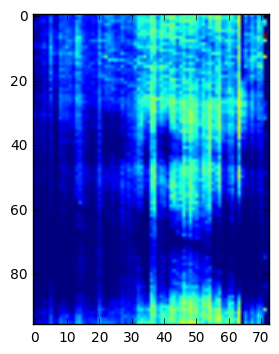

In [26]:
plt.imshow(speeding_statistics/(total_statistics+0.001))

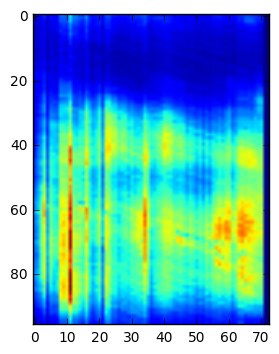

In [28]:
plt.imshow((total_statistics))

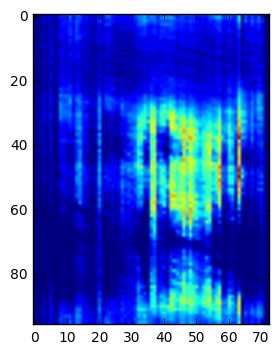

In [29]:
plt.imshow((speeding_statistics))

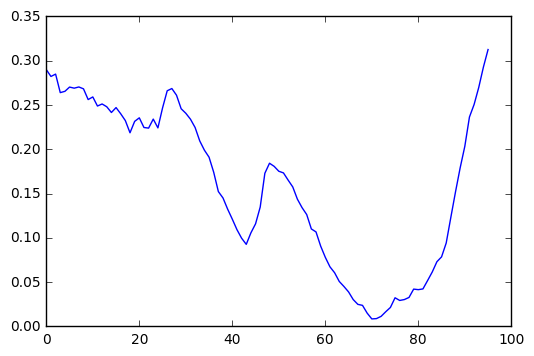

In [32]:
plt.plot(speeding_statistics.sum(axis=1)/(total_statistics.sum(axis=1)+0.00001) )

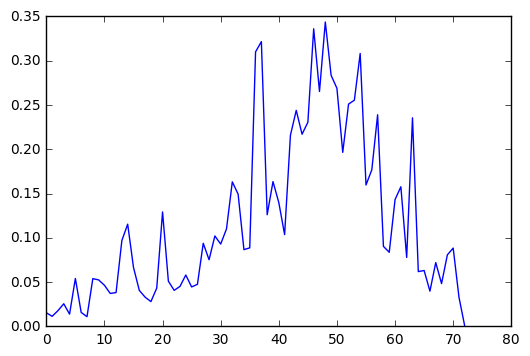

In [33]:
plt.plot(speeding_statistics.sum(axis=0)/(total_statistics.sum(axis=0)+0.00001) )